# Classical Baselines 
For comparison against quantum methods


In [14]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import seaborn as sns 
from sklearn.decomposition import PCA
import joblib


In [2]:
data = np.load("data/mnist01_pca4.npz")    #from dataprep notebook

X_train, y_train = data["X_train"], data["y_train"]  
X_test, y_test = data["X_test"], data["y_test"]

### 2d PCA for visualization 

reduce PCA to 2 features for visualization purposes only, allows us to plot the decision boundary in the SVM (SVMs are stricter, checks X.shape[1] against n_features_in so we cannot feed a 2d meshgrid (2 features) into a model trained on 4)

actual model is still trained on 4 features, this is **visualization purposes only**

In [3]:
pca_2d = PCA(n_components=2)
X_train_2d = pca_2d.fit_transform(X_train)
X_test_2d = pca_2d.transform(X_test)

scaler_2d = StandardScaler()
X_train_2d_scaled = scaler_2d.fit_transform(X_train_2d)
X_test_2d_scaled = scaler_2d.transform(X_test_2d)


## Logistic Regression

In [4]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [5]:
y_pred = model.predict(X_test_scaled)  
accuracy = accuracy_score(y_test, y_pred) 


print("Accuracy: {:.2f}% \n".format(accuracy*100))
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))    
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 99.62% 

Confusion Matrix: 
 [[ 976    4]
 [   4 1131]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135

    accuracy                           1.00      2115
   macro avg       1.00      1.00      1.00      2115
weighted avg       1.00      1.00      1.00      2115



The results of the Logistic Regression suggest that near perfection is achieved, with a 99.67% accuracy when classifying 0s and 1s, along with only 7/2115 incorrect results according to the confusion matrix. 

The scores for precision and recall (for classes 0 and 1) are 1.0, meaning almost every time the model predicted 0 or 1 it was correct and almost all actual 0s and 1s were found. The f1 score is also 1.0 due to this. 

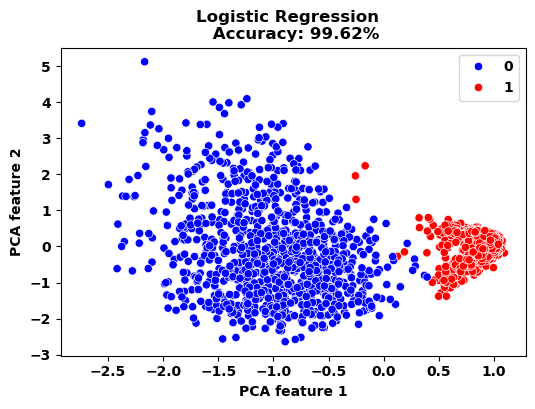

In [6]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=X_test_scaled[:,0], y=X_test_scaled[:,1], hue=y_test, palette={
    0:'blue', 1:'red'}) 

plt.xlabel("PCA feature 1")
plt.ylabel("PCA feature 2")
plt.title("Logistic Regression  \n Accuracy: {:.2f}%".format(accuracy*100))
plt.show()

In this decision boundary plot, 0s and 1s are clearly seperated (clustered) in feature space, so having a simple linear boundary such as logistic regression works very well and why the accuracy is so high (problem is linearly seperable in reduced PCA space). 


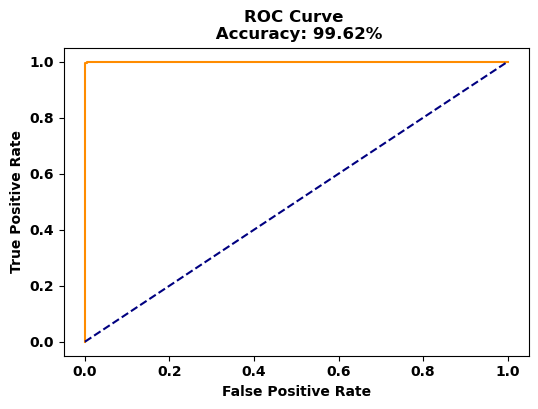

In [7]:
y_prob = model.predict_proba(X_test_scaled)[:,1]
fpr, tpr,thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--', label='random')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve \n Accuracy: {:.2f}%".format(accuracy*100))
plt.show()


The orange curve, meaning AUC =1.0, is very close to the top left corner. This means the model is very confident and almost never makes mistakes between the classes. The random line (dashed, navy) is the baseline and the model considerably outperforms it. 


## SVM (support vector machine)

supervised learning algorithms to identify the optimal decision boundary (more complex then logistic regression)

In [8]:
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier.fit(X_train_scaled, y_train)


,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [9]:
y_pred = svm_classifier.predict(X_test_scaled)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}\n")  
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))    
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 1.00

Confusion Matrix: 
 [[ 976    4]
 [   4 1131]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135

    accuracy                           1.00      2115
   macro avg       1.00      1.00      1.00      2115
weighted avg       1.00      1.00      1.00      2115



The results of the SVM also suggest that near perfection is achieved, with a 1.00% accuracy when classifying 0s and 1s, along with only 6/2115 incorrect results (1 mistake better than Log Reg) according to the confusion matrix. 

The scores for precision and recall (for classes 0 and 1) are 1.0, meaning almost every time the model predicted 0 or 1 it was correct and almost all actual 0s and 1s were found. The f1 score is also 1.0 due to this. 

In [10]:
def plot_decision_bound(X, y, model, scaler):
    h=0.02  #step size for mesh
    x_min, x_max = X[:,0].min()-1, X[:,0].max()+1
    y_min, y_max = X[:,1].min()-1, X[:,1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), 
                        np.arange(y_min, y_max,h))

    #predicts on mesh points   
    Z = model.predict(scaler.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(6,4))
    plt.contourf(xx, yy, Z,cmap=plt.cm.coolwarm, alpha=0.3)
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title('SVM Decision Boundary')
    plt.show()



Here is where we use the 2d PCA in order to visualize the SVM 

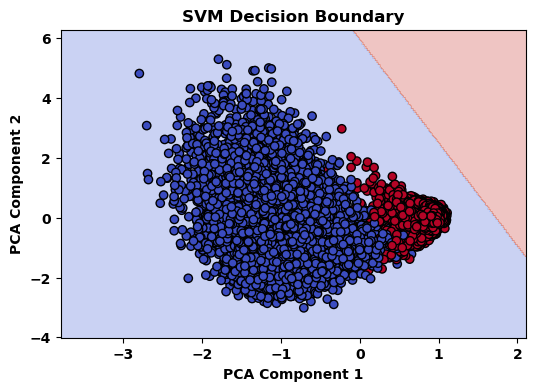

In [11]:
svm_classifier_2d = SVC(kernel='linear', C=1.0, random_state=42)
svm_classifier_2d.fit(X_train_2d_scaled, y_train)

plot_decision_bound(X_train_2d_scaled, y_train, svm_classifier_2d, scaler_2d)

This graph defines the regions where SVM is predicting the classes 1 (red) or 0 (blue), with each dot being a sample from the training data in the 2d PCA space. 

The line is the linear seperation betwee 0/1 in the PCA space and it is mostly verticle due to fact the first PCA component captures the most variance that is seperating the classes. There are a few misclassified points near the boundary but that is to be expected. Overall, the SVM is seperating 0s and 1s almost perfectly. 

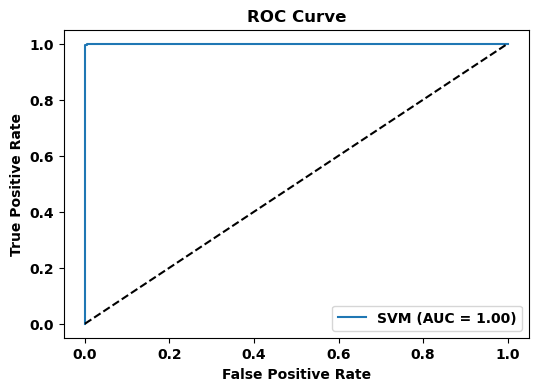

In [12]:
y_scores = svm_classifier.decision_function(X_test_scaled)      #returns distance to hyperplane (higher distance, more confident prediction)

# y_probs = svm_classifier.predict_proba(X_test_scaled)[:,1]    #gives probs between 0-1
y_scores = svm_classifier.decision_function(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'SVM (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The ROC is very similar for the SVM and the Log Regresion. Both have an AUC (area under curve) of 1.0, indicating almost perfect seperation (which makes sense considering how easily seperable the classes are in PCA space). 

The SVM is also very confident in seperating 0s and 1s, as seen with the very steep curve that touches the top left corner of the graph. 

## Takeaways

Both Logistic Regression and SVM perform extremely well on this dataset, as it is easily seperable in PCA space and the 0s/1s can be classified very easily. They both have near perfect accuracy and AUC. 

Neither one of the classical models outperforms the other in a meaningful extent, indicating both will provide a good baseline model to compare my quantum model against in the following steps. 

## Save Models

In [15]:
joblib.dump(model, "../results/models/log_reg.pkl")
joblib.dump(svm_classifier, "../results/models/svm.pkl")


['../results/models/svm.pkl']